In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

## Initial conditions

In [2]:
def flat_u(j):
    """produces a flat line at zero"""
    y = 0
    return y

def h_spike(j, midpoint):
    """produces a curve which is zero everywhere but h = 1 at one point in the cente"""
    if j == midpoint:
        y = 1
    else:
        y = 0
    return y

def h_cosbell(j):
    """produces a curve which has a bump in the centre and is surrounded by zero either side"""
    if 0.25 <= j <= 0.75:
        y = math.cos(2*(math.pi)*(j - 0.5))
    else:
        y = 0
    return y

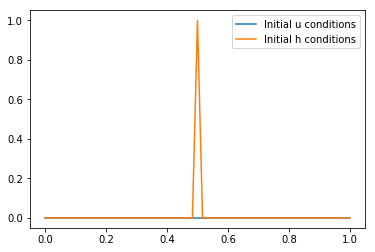

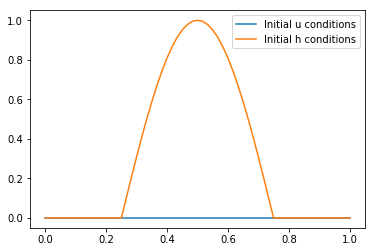

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          6.12323400e-17,   1.04528463e-01,   2.07911691e-01,
          3.09016994e-01,   4.06736643e-01,   5.00000000e-01,
          5.87785252e-01,   6.69130606e-01,   7.43144825e-01,
          8.09016994e-01,   8.66025404e-01,   9.13545458e-01,
          9.51056516e-01,   9.78147601e-01,   9.94521895e-01,
          1.00000000e+00,   9.945

In [3]:

nx = 60 # number of points from x = 0 to x = 1
nt = 500

def initialconditions_spike(nx, nt, plot = True):
    """
    nx: number of space steps
    nt: number of time steps
    plot: if this variable is True then the initial conditions will be plotted, but it False then no plot will be produced
    """
    x = np.linspace(0,1,nx+1) # want the extra point at the boundary for plot but in reality h[0] and h[nx] are equal
    midpoint = math.floor(math.floor(len(x)/2)/2)*2 
    
    # initialize initial u and initial h
    initialu = np.zeros(len(x)).astype(float)
    initialh = np.zeros(len(x)).astype(float)
    
    # set the initial conditions such that u is zero everywhere and h is zero everywhere apart from one point at the centre where it is one
    for i in range(len(x)):
        initialu[i] = flat_u(i)
        initialh[i] = h_spike(i, midpoint)
    
    # plot these initial conditions
    if plot == True:
        plt.clf()
        plt.ion()
        plt.plot(x, initialu, label = 'Initial u conditions')
        plt.plot(x, initialh, label = 'Initial h conditions')
        plt.legend(loc = 'best')
        plt.show()
        
    return initialu, initialh, midpoint, x

# plot initial conditions where u is zero everywhere and h is zero everywhere apart from one point at the centre where it is one
initialconditions_spike(nx, nt)

def initialconditions_cosbell(nx, nt, plot = True):
    """
    nx: number of space steps
    nt: number of time steps
    plot: if this variable is True then the initial conditions will be plotted, but it False then no plot will be produced
    """
    x = np.linspace(0,1,nx+1) # want the extra point at the boundary but in reality h[0] and h[nx] are equal
    
    midpoint = math.floor(math.floor(len(x)/2)/2)*2 # calculate midpoint to be used for the forcing term
    
    # initialize initial u and initial h
    initialu = np.zeros(len(x)).astype(float)
    initialh = np.zeros(len(x)).astype(float)
    
    # set the initial conditions such that u is zero everywhere and h has a bump in the centre and is surrounded by zero either side
    for i in range(len(x)):
        initialu[i] = flat_u(i)
        initialh[i] = h_cosbell(x[i])
        
    # plot these initial conditions
    if plot == True:
        plt.clf()
        plt.ion()
        plt.plot(x, initialu, label = 'Initial u conditions')
        plt.plot(x, initialh, label = 'Initial h conditions')
        plt.legend(loc = 'best')
        plt.show()
    return initialu, initialh, midpoint, x

# plot initial conditions where u is zero everywhere and h has a bump in the centre and is surrounded by zero either side
initialconditions_cosbell(nx,nt)

### Forcing term is $f= 20\sqrt{(gH)}\sin(\omega t)$ at $ x = 0.5$

## A-grid

In [4]:
def A_grid(initialconditions, nx, nt, H = 1, g = 1, w = 8, c = 0.1, Forcing = False):
    """This function simulates the shallow water equations using the colocated scheme

    initial conditions: function which specifies the initial conditions for the system 
    nx:                 number of space steps
    nt:                 number of time steps
    H:                  mean fluid depth set to 1 unless otherwise specified
    g:                  acceleration due to gravity scaled to 1
    w:                  frequency of forcing term
    c:                  courant number (c = root(gH)dt/dx)
    Forcing:            if this variable is True then a forcing term will be included 
                        in the scheme. If False no forcing term will be included
    """
    
    # set initial conditions
    initialu, initialh, midpoint, x = initialconditions(nx,nt, plot = False)
    
    # initialize the system
    uOld = initialu.copy()
    hOld = initialh.copy()
    u = np.zeros_like(uOld)
    h = np.zeros_like(hOld)

    dx = 1/nx
    dt = (c*dx)/math.sqrt(g*H)

    # loop over time steps
    for it in range(int(nt)): 
        for y in range(nx):
            # forward in time and centred in space
            u[y%nx] = uOld[y%nx] - (c*math.sqrt(g/H)/2)*(hOld[(y+1)%nx] - hOld[(y-1)%nx])
            
            # backward in time and centred in space
            if Forcing == True:
                # add forcing term at midpoint
                if y == midpoint:
                    h[y%nx] = hOld[y%nx] - (c*math.sqrt(H/g)/2)*(u[(y+1)%nx] - u[(y-1)%nx]) + 20*dt*math.sqrt(g*H)*math.sin(w*it*dt)
                else:
                    h[y%nx] = hOld[y%nx] - (c*math.sqrt(H/g)/2)*(u[(y+1)%nx] - u[(y-1)%nx])
            elif Forcing == False:    
                h[y%nx] = hOld[y%nx] - (c*math.sqrt(H/g)/2)*(u[(y+1)%nx] - u[(y-1)%nx]) # backward in time and centred in space
            else:    
                print("Error: Forcing must be true or false")
                break
                
        # set periodic boundary conditions
        u[nx] = u[0].copy()
        h[nx] = h[0].copy()
        
        # copy u and h for next iteration
        hOld = h.copy()
        uOld = u.copy()
    return u, h, x

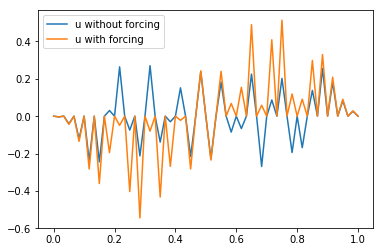

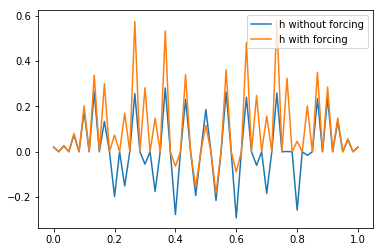

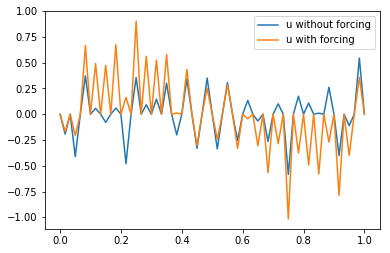

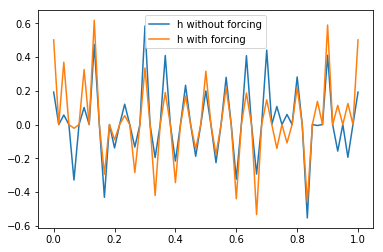

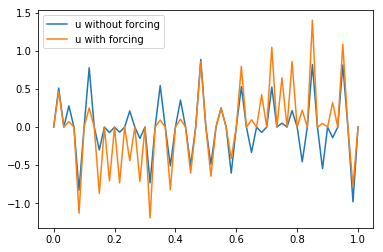

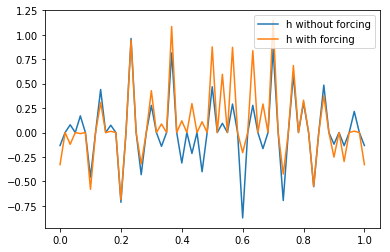

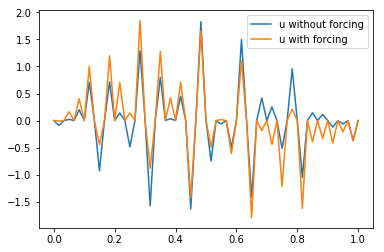

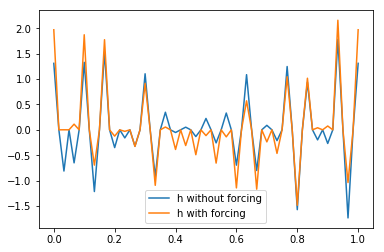

In [5]:
timerange = np.linspace(0, 2, 5)

# plot solution at various time iterations for colocated grid for the initial condition where u is zero everywhere 
# and h is zero everywhere apart from one point at the centre where it is one
for i in timerange[1:]:
    u, h, x1 = A_grid(initialconditions_spike, nx, i*nt, Forcing = False)
    u_forcing, h_forcing, x2 = A_grid(initialconditions_spike, nx, i*nt, Forcing = True)

    plt.ion()
    plt.plot(x1, u, label = 'u without forcing')
    plt.plot(x2, u_forcing, label = 'u with forcing')
    plt.legend(loc = 'best')
    plt.show()

    plt.plot(x1, h, label = 'h without forcing')
    plt.plot(x2, h_forcing, label = 'h with forcing')
    plt.legend(loc = 'best')
    plt.show()

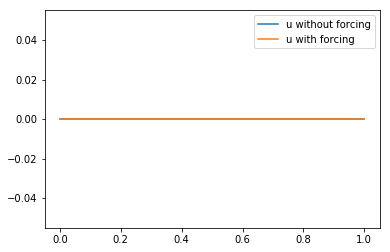

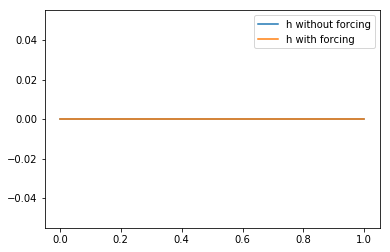

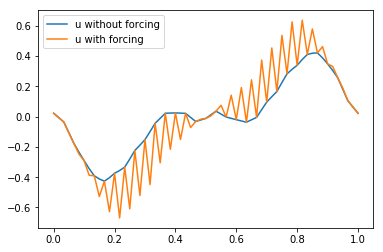

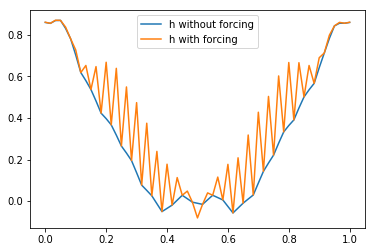

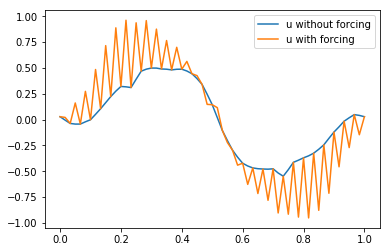

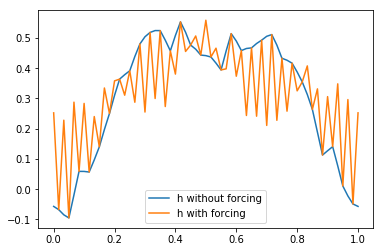

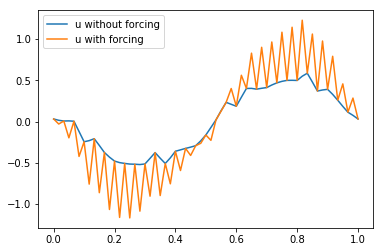

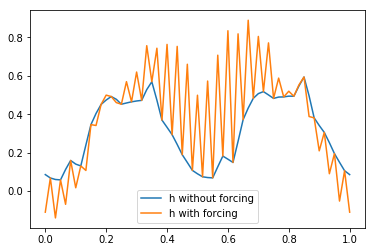

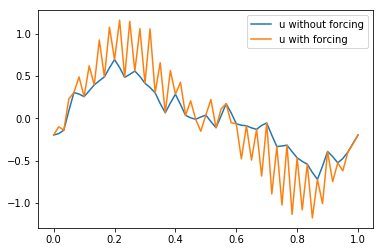

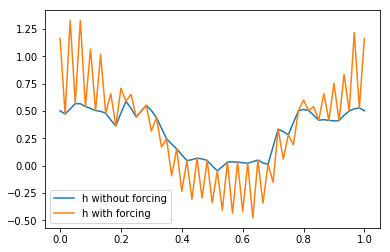

In [6]:
timerange = np.linspace(0, 2, 5)

# plot solution at various time iterations for colocated grid for the initial condition where u is zero everywhere 
# and h has a bump in the centre and is surrounded by zero either side
for i in timerange:
    u, h, x1 = A_grid(initialconditions_cosbell, nx, i*nt, H = 1, g = 1, w = 8, Forcing = False)
    u_forcing, h_forcing, x2 = A_grid(initialconditions_cosbell, nx, i*nt, H = 1, g = 1, w = 8, Forcing = True)

    plt.ion()
    plt.plot(x1, u, label = 'u without forcing')
    plt.plot(x2, u_forcing, label = 'u with forcing')
    plt.legend(loc = 'best')
    plt.show()

    plt.plot(x1, h, label = 'h without forcing')
    plt.plot(x2, h_forcing, label = 'h with forcing')
    plt.legend(loc = 'best')
    plt.show()

## C-grid

In [7]:
def C_grid(initialconditions, nx, nt, H = 1, g = 1, w = 8, c = 0.1, Forcing = False):
    """This function simulates the shallow water equations using the staggered scheme

    initial conditions: function which specifies the initial conditions for the system 
    nx:                 number of space steps
    nt:                 number of time steps
    H:                  mean fluid depth set to 1 unless otherwise specified
    g:                  acceleration due to gravity scaled to 1
    w:                  frequency of forcing term
    c:                  courant number (c = root(gH)dt/dx)
    Forcing:            if this variable is True then a forcing term will be included 
                        in the scheme. If False no forcing term will be included
    """
    # set initial conditions
    initialu, initialh, midpoint, x = initialconditions(nx,nt, plot = False)
    
    
    uhalf = np.zeros(len(initialu))
    
    # for a c-grid the velocity u is stagerred in the x-direction by half
    for i in range(0, len(initialu)):
        uhalf[i] = flat_u(i+1/2)
        # therefore uhalf[i] = u_{i + 1/2}
    
    # initialize the system
    u_cgrid = np.zeros_like(uhalf)
    h_cgrid = np.zeros_like(initialh)
    
    uOld = uhalf.copy()
    hOld = initialh.copy()

    dx = 1/nx
    dt = (c*dx)/math.sqrt(g*H)
    
    # loop over time steps
    for it in range(int(nt)): 
        for y in range(nx):
            # forward in time and centred in space
            uhalf[(y)%nx] = uOld[y%nx] - (c*math.sqrt(g/H))*(hOld[(y + 1)%nx] - hOld[y%nx]) 
            # backward in time and centred in space
            if Forcing == True:
            # add forcing term at midpoint
                if y == midpoint:
                    h_cgrid[y%nx] = hOld[y%nx] - (c*math.sqrt(H/g))*(uhalf[y%nx] - uhalf[(y-1)%nx]) + 20*dt*math.sqrt(g*H)*math.sin(w*dt*it)# backward in time and centred in space
                else:
                    h_cgrid[y%nx] = hOld[y%nx] - (c*math.sqrt(g/H))*(uhalf[y%nx] - uhalf[(y-1)%nx])
            elif Forcing == False:    
                h_cgrid[y%nx] = hOld[y%nx] - (c*math.sqrt(g/H))*(uhalf[y%nx] - uhalf[(y-1)%nx]) 
            else:
                print("Error: Forcing must be true or false")
                break
        
        # set periodic boundary conditions
        uhalf[nx] = uhalf[0].copy()
        h_cgrid[nx] = h_cgrid[0].copy()
        
        # copy u and h for next iteration
        hOld = h_cgrid.copy()
        uOld = uhalf.copy()
    return uhalf, h_cgrid, x

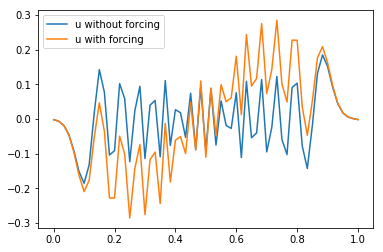

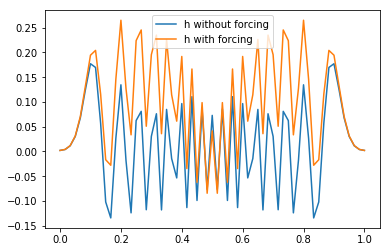

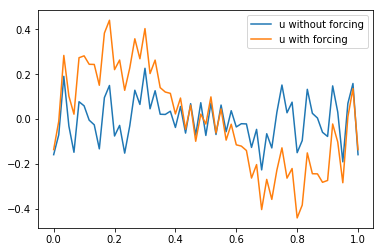

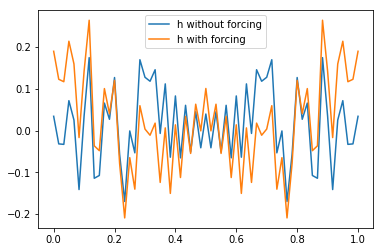

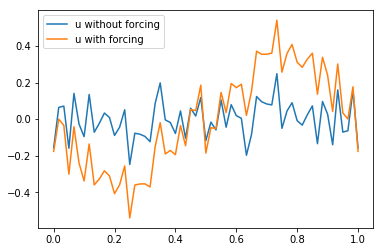

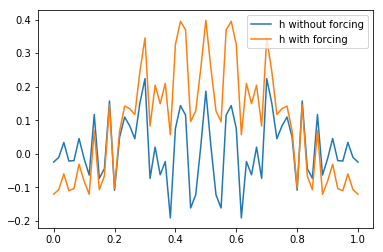

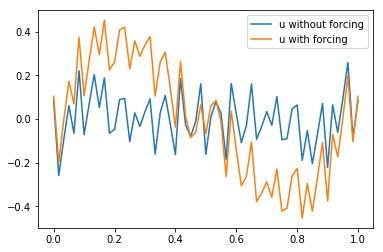

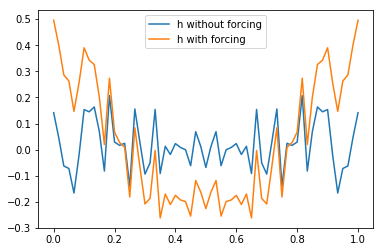

In [9]:
timerange = np.linspace(0, 2, 5)

# plot solution at various time iterations for staggered grid for the initial condition where u is zero everywhere 
# and h is zero everywhere apart from one point at the centre where it is one
for i in timerange[1:]:
    u, h, x1 = C_grid(initialconditions_spike, nx, i*nt, Forcing = False)
    u_forcing, h_forcing, x2 = C_grid(initialconditions_spike, nx, i*nt, Forcing = True)

    plt.ion()
    plt.plot(x1, u, label = 'u without forcing')
    plt.plot(x2, u_forcing, label = 'u with forcing')
    plt.legend(loc = 'best')
    plt.show()

    plt.plot(x1, h, label = 'h without forcing')
    plt.plot(x2, h_forcing, label = 'h with forcing')
    plt.legend(loc = 'best')
    plt.show()

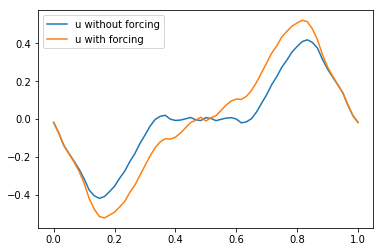

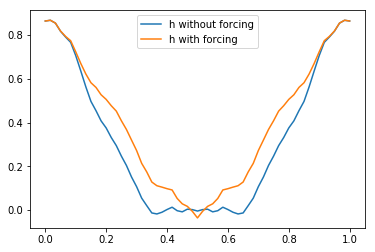

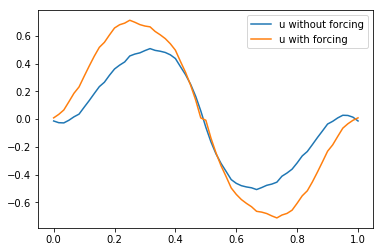

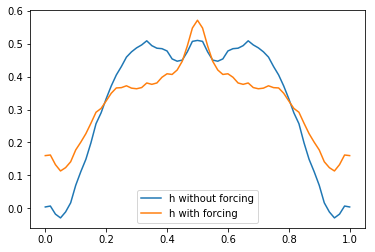

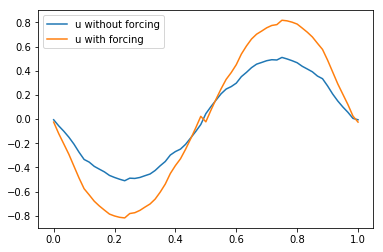

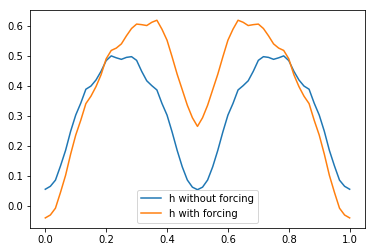

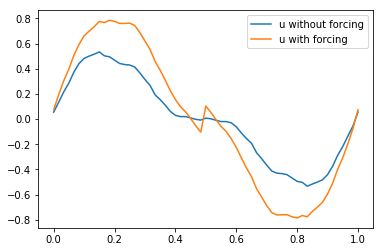

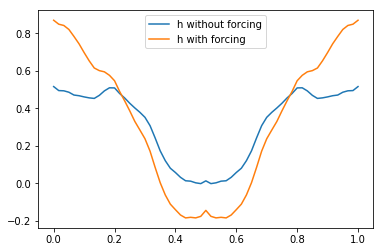

In [10]:
timerange = np.linspace(0, 2, 5)

# plot solution at various time iterations for staggered grid for the initial condition where u is zero everywhere 
# and h has a bump in the centre and is surrounded by zero either side
for i in timerange[1:]:
    u, h, x1 = C_grid(initialconditions_cosbell, nx, i*nt, H = 1, g = 1, w = 8, Forcing = False)
    u_forcing, h_forcing, x2 = C_grid(initialconditions_cosbell, nx, i*nt, H = 1, g = 1, w = 8, Forcing = True)

    plt.ion()
    plt.plot(x1, u, label = 'u without forcing')
    plt.plot(x2, u_forcing, label = 'u with forcing')
    plt.legend(loc = 'best')
    plt.show()

    plt.plot(x1, h, label = 'h without forcing')
    plt.plot(x2, h_forcing, label = 'h with forcing')
    plt.legend(loc = 'best')
    plt.show()